In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from modules.StochasticProcess import StochasticProcess
from modules.ECGcleaner import ECGcleaner
from modules.QRSdetector import QRSdetector
from modules.ECGestimator import ECGestimator
from sklearn.decomposition import FastICA
from modules.Evaluator import Evaluator

In [5]:
def extract_stochastic_process(filename, num_realizations):
    df = pd.read_csv(filename, skiprows=2, header=None)
    realizations, labels = [], []
    for i in range (1,num_realizations+1):
        AECG = df[i].to_numpy()
        AECG_cleaned = np.where(AECG == '-', '0', AECG)
        realizations.append(AECG_cleaned.astype(float))
        labels.append("AECG"+str(i))

    return realizations, labels

In [6]:
data_extension = ".csv"
gt_extension = ".fqrs.txt"
data_path = "../data/set-a-text"

csv_paths, gt_paths, sps = [], [], []

for file in os.listdir(data_path):
    if file.endswith(data_extension): 
        csv_paths.append(os.path.join(data_path, file))
        sps.append(file.split(".")[0])    
    if file.endswith(gt_extension): gt_paths.append(os.path.join(data_path, file))

csv_paths = sorted(csv_paths)
gt_paths = sorted(gt_paths)
sps = sorted(sps)

FHRs = {}

In [7]:
# PARAMETERS

# general
num_realizations = 4
sr = 1000 
colors = ['blue', 'green', 'orange', 'red']

# baseline_wander_remover
BW_freq = 3
BW_num_taps = 1000

# PLI remover
PLI_freq = 50
notch_quality_factor = 30

# upsampling
upsample_factor = 2
new_sr = sr * upsample_factor

# MQRS detection
maternal_template_duration = 0.10
maternal_threshold_factor = 0.5

# MECG canceller
maternal_P_wave_duration = 0.20
maternal_T_wave_duration = 0.40

# FQRS detection
fetal_duration_template = 0.10
fetal_threshold_factor = 0.3

# FECG detection
fetal_P_wave_duration = 0.20
fetal_T_wave_duration = 0.40

results_path = "../results"

In [9]:
def sequential_analysis(S1, num_realizations, labels, colors, sr, gt, sp):
    ecg_cleaner = ECGcleaner(sr, BW_freq, PLI_freq)

    # Baseline Wander removal
    S2 = StochasticProcess(num_realizations, [ecg_cleaner.remove_baseline_wander(r, BW_num_taps+1) for r in S1], labels, colors, sr)

    # PLI removal
    S3 = StochasticProcess(num_realizations, [ecg_cleaner.remove_PLI_notch(r, notch_quality_factor) for r in S2], labels, colors, sr)

    # upsampling
    S4 = S2.resample_process(new_sr)

    # MQRS detection
    MQRS_detector = QRSdetector(S4, maternal_template_duration, maternal_threshold_factor, new_sr)
    maternal_enhanced_QRS, _ = MQRS_detector.get_enhanced_QRS()
    maternal_qrs_template = MQRS_detector.create_qrs_template(maternal_enhanced_QRS)
    maternal_peaks, _ = MQRS_detector.detect_qrs(maternal_enhanced_QRS, maternal_qrs_template)

    # MECG estimation and cancellation
    MECG_estimator = ECGestimator(S4, maternal_P_wave_duration, maternal_template_duration, maternal_T_wave_duration, new_sr, labels)
    real_MECGs, real_MECGs_positions = MECG_estimator.get_real_ECGs(maternal_peaks)
    MECG_averages = MECG_estimator.get_ECG_averages(real_MECGs)
    mu_portions = MECG_estimator.get_mu_portions(MECG_averages)
    M_matrixes = MECG_estimator.get_M_matrixes(mu_portions)
    estimated_MECGs = MECG_estimator.get_estimated_ECGs(real_MECGs, M_matrixes, mu_portions)
    residual_realizations = []
    for i in range(num_realizations): 
        residual_realizations.append(MECG_estimator.cancel_ECG(S4.get_realization_by_index(i), real_MECGs_positions[labels[i]], real_MECGs[labels[i]], estimated_MECGs[labels[i]]))
    S5 = StochasticProcess(num_realizations, residual_realizations, labels, colors, new_sr)

    # FQRS detection
    gt_fetal_peaks = gt * upsample_factor
    FQRS_detector = QRSdetector(S5, fetal_duration_template, fetal_threshold_factor, new_sr)
    fetal_enhanced_QRS, _ = FQRS_detector.get_enhanced_QRS()
    fetal_QRS_template = FQRS_detector.create_qrs_template(fetal_enhanced_QRS)
    fetal_peaks, _ = FQRS_detector.detect_qrs(fetal_enhanced_QRS, fetal_QRS_template)

    # FECG estimation
    FECG_estimator = ECGestimator(S5, fetal_P_wave_duration, fetal_duration_template, fetal_T_wave_duration, new_sr, labels)
    real_FECGs, real_FEGCs_positions = FECG_estimator.get_real_ECGs(fetal_peaks)
    FECG_averages = FECG_estimator.get_ECG_averages(real_FECGs)
    gt_FECG_averages = FECG_estimator.get_ECG_averages(FECG_estimator.get_real_ECGs(gt_fetal_peaks)[0])
    S6 = StochasticProcess(num_realizations, [FECG_averages[label] for label in FECG_averages], labels, colors, new_sr)

    # save results
    gt_S6 = StochasticProcess(num_realizations, [gt_FECG_averages[label] for label in gt_FECG_averages], labels, colors, new_sr)
    evaluator = Evaluator(S6, gt_S6)

    correlations, _ = evaluator.get_correlations()
    MSEs, _ = evaluator.get_MSEs()
    evaluator.plot_comparison(correlations, MSEs, os.path.join(results_path, sp), plot=False, save=False)
    return real_FEGCs_positions, fetal_peaks, S4, S5, S6

In [14]:
def ICA_analysis(S1, num_realizations, labels, colors, gt_peaks, component_to_choose=1):
    ecg_cleaner = ECGcleaner(sr, BW_freq, PLI_freq)

    # Baseline Wander removal
    S2 = StochasticProcess(num_realizations, [ecg_cleaner.remove_baseline_wander(r, BW_num_taps+1) for r in S1], labels, colors, sr)

    # PLI removal
    S3 = StochasticProcess(num_realizations, [ecg_cleaner.remove_PLI_notch(r, notch_quality_factor) for r in S2], labels, colors, sr)

    signal = []
    for realization in S3: signal.append(realization)

    signal -= np.mean(signal, axis=1, keepdims=True)
    signal /= np.std(signal, axis=1, keepdims=True)

    ica = FastICA(n_components=signal.shape[0], random_state=42)
    independent_components = ica.fit_transform(signal.T).T 

    plt.figure(figsize=(12, 8))
    for i, component in enumerate(independent_components):
        plt.subplot(signal.shape[0], 1, i + 1)
        plt.plot(component)
        plt.title(f'Component {i+1}')
    plt.tight_layout()
    plt.show()

    fecg_signal = independent_components[component_to_choose]

    ICA_template_duration = 0.1
    ICA_threshold_factor = 0.3
    ICA_sr = 1000
    ICA_QRS_detector = QRSdetector(S1, ICA_template_duration, ICA_threshold_factor, ICA_sr)
    
    # The "component_to_choose" independent component is assumed to be the fetal_enhanced_QRS
    ICA_QRS_template = ICA_QRS_detector.create_qrs_template(fecg_signal)
    ICA_peaks, ICA_cross_corr = ICA_QRS_detector.detect_qrs(fecg_signal, ICA_QRS_template)

    corr_max = np.max(ICA_cross_corr)
    print(f"ICA QRS peaks detected: {len(ICA_peaks)}, with correlation threshold factor: {round(ICA_threshold_factor*100)} %")
    print(f"QRS peaks (ground truth): {len(gt_peaks)}")
    
    plt.figure(figsize=(14, 8))

    time = S3.timestamps

    # Enhanced QRS (with detected peaks)
    plt.subplot(2, 1, 1)
    plt.plot(time, fecg_signal, label=f"enhanced QRS")
    plt.scatter(time[ICA_peaks], fecg_signal[ICA_peaks], color='red', label="Detected ICA QRS", zorder=2)
    plt.scatter(time[gt_peaks], fecg_signal[gt_peaks], color='orange', label="Ground Truth QRS peaks", zorder=2)
    plt.title(f"Independent Component {component_to_choose+1}")

    plt.legend()
    plt.xlabel("Time [s]")
    plt.xlim(18, 30)
    plt.ylabel("Amplitude")
    plt.grid()

    # Cross-correlation
    plt.subplot(2, 1, 2)
    plt.plot(time[:len(ICA_cross_corr)], ICA_cross_corr, label="Normalized ICA Cross Correlation")
    plt.axhline(y=ICA_threshold_factor*corr_max, color='red', linestyle='--', label="Threshold")
    plt.legend()
    plt.xlim(18, 30)
    plt.xlabel("Time [s]")
    plt.ylabel("Correlation")
    plt.grid()

    plt.tight_layout()
    plt.show()

    return ICA_peaks

# **Misurazione Performance**

### **1) FHR Evaluation: Comparison with ICA**

As a reference for the fetal heart rate (FHR), we use the ground truth peaks: for example, if the ground truth peaks indicate 120, it means that it was empirically measured that the fetus's heart was beating at 120 bpm.  
To assess the quality of the extracted FHR, the QRS detection method needs to be applied to a signal containing the fetal ECG obtained using a method different from the sequential approach. Thus:

- Stochastic Process $\rightarrow$ sequential_approach $\rightarrow$ sequential_peaks  
- Stochastic Process $\rightarrow$ preprocessing $\rightarrow$ **ICA** $\rightarrow$ Independent Component associated with FECG $\rightarrow$ QRS_detection $\rightarrow$ ICA_peaks  

Which of the two aligns more closely with the ground truth for each process?

**NOTE**: The peaks detected by ICA are not necessarily fetal peaks. This happens only if the independent component being considered is plausibly associated with the fetal signal.


In [11]:
for i in range(len(csv_paths)):
    sp_path = csv_paths[i]
    gt_path = gt_paths[i]

    # fetal peaks (ground truth)
    with open(gt_path, 'r') as file: gt = np.array([int(line.strip()) for line in file])
    
    # realizations
    realizations, labels = extract_stochastic_process(sp_path, num_realizations)
    S1 = StochasticProcess(num_realizations, realizations, labels, colors, sr)

    # sequential analysis
    try:
        _, estimated_fetal_peaks, _, _, _ = sequential_analysis(S1, num_realizations, labels, colors, sr, gt, sps[i])
        FHRs[sp_path] = (len(estimated_fetal_peaks), len(gt))
        print(f"Successfully estimated FHR for subject {sp_path[-7:].split(".")[0]}")
        print(f"Estimated FHR: {len(estimated_fetal_peaks)} bpm | Actual FHR: {len(gt)} bpm")
        print("------------------------------------------------------------------------------------\n")

    except:
        print(f">> Unable to estimate FHR for {sp_path}")        


Successfully estimated FHR for subject a01
Estimated FHR: 118 bpm | Actual FHR: 145 bpm
------------------------------------------------------------------------------------

Successfully estimated FHR for subject a02
Estimated FHR: 102 bpm | Actual FHR: 160 bpm
------------------------------------------------------------------------------------

Successfully estimated FHR for subject a03
Estimated FHR: 126 bpm | Actual FHR: 128 bpm
------------------------------------------------------------------------------------

Successfully estimated FHR for subject a04
Estimated FHR: 128 bpm | Actual FHR: 129 bpm
------------------------------------------------------------------------------------

Successfully estimated FHR for subject a05
Estimated FHR: 126 bpm | Actual FHR: 129 bpm
------------------------------------------------------------------------------------

Successfully estimated FHR for subject a06
Estimated FHR: 68 bpm | Actual FHR: 160 bpm
-------------------------------------------

../data/set-a-text/a09.csv


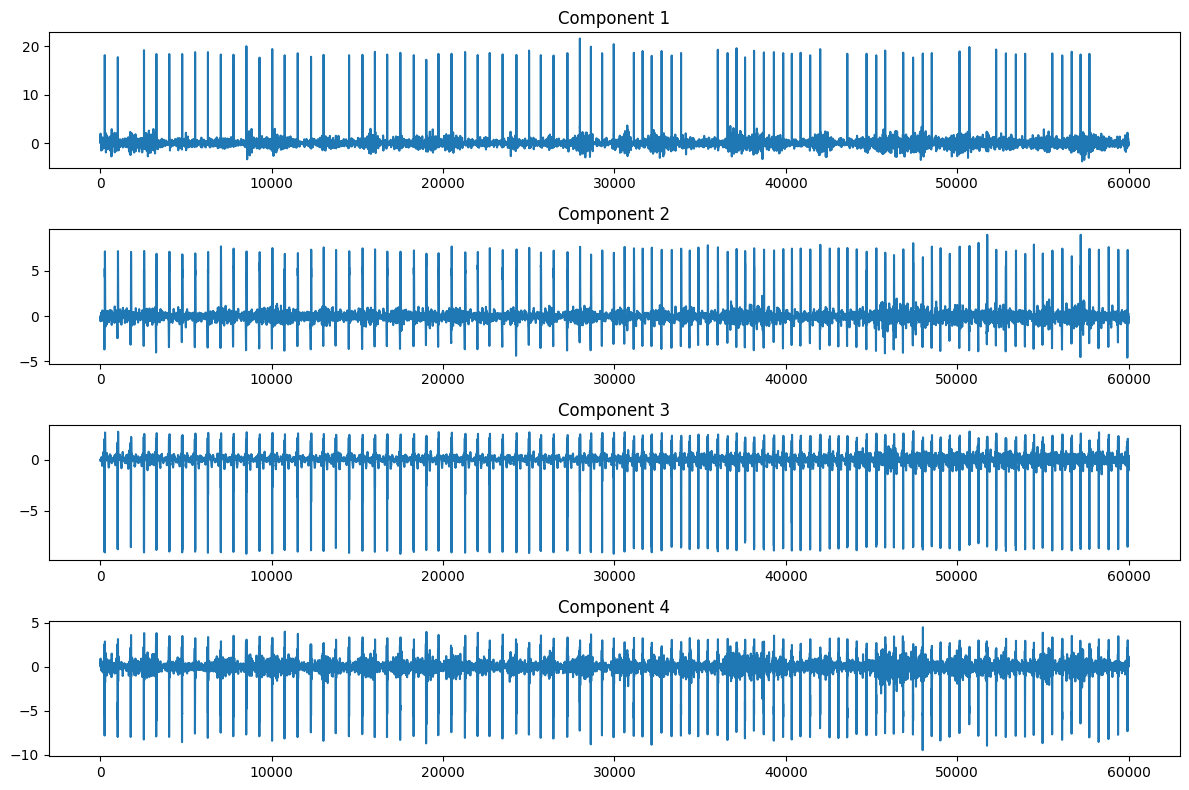

ICA QRS peaks detected: 96, with correlation threshold factor: 30 %
QRS peaks (ground truth): 130


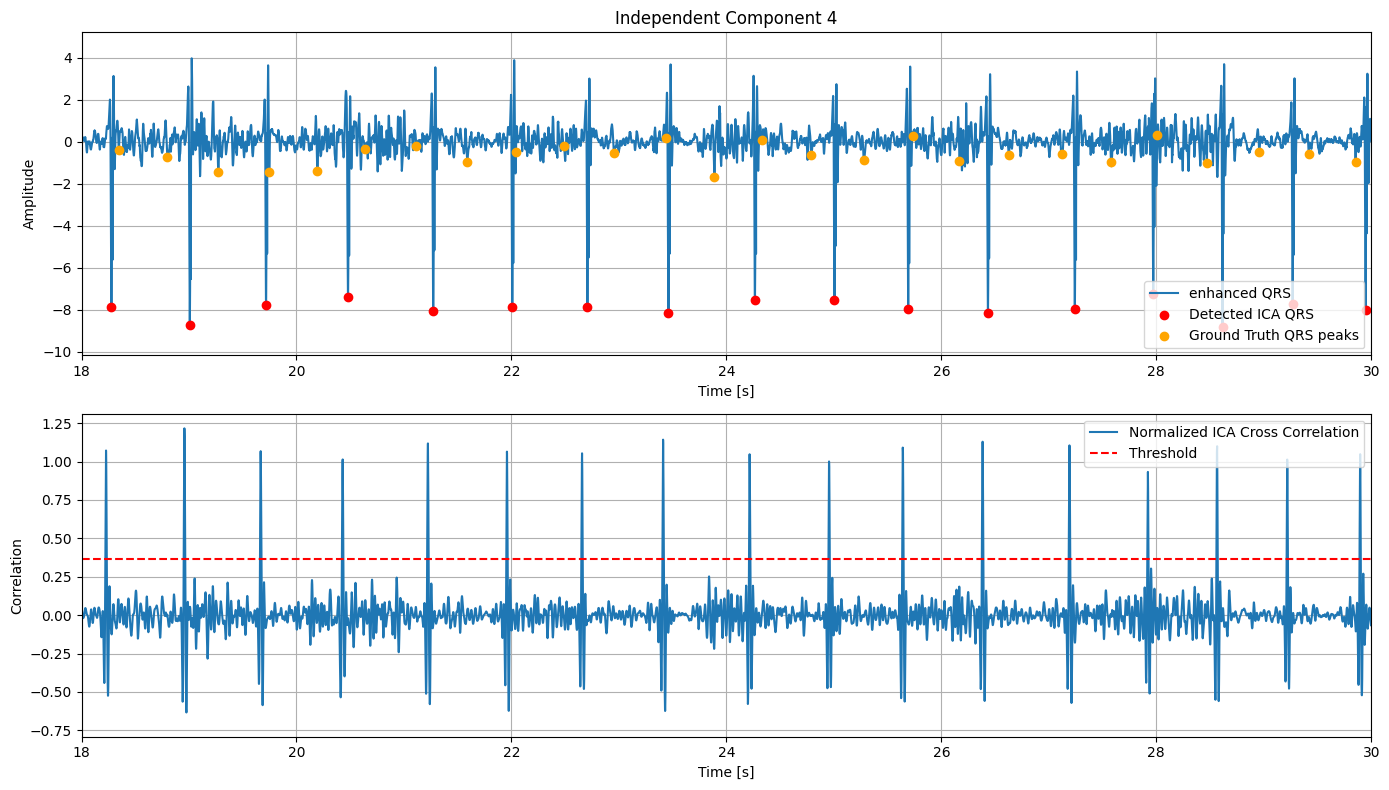

In [17]:
# TEST ICA

subject_index = 8

sp_path = csv_paths[subject_index]
gt_path = gt_paths[subject_index]

print(sp_path)

# fetal peaks (ground truth)
with open(gt_path, 'r') as file: gt = np.array([int(line.strip()) for line in file])

# realizations
realizations, labels = extract_stochastic_process(sp_path, num_realizations)
S1 = StochasticProcess(num_realizations, realizations, labels, colors, sr)

ica_peaks = ICA_analysis(S1, num_realizations, labels, colors, gt, component_to_choose=3)



The issue with ICA applied to this dataset is that, as often happens with PCA and ICA, it is challenging to associate an extracted component with the actual source.

Following a visual analysis, which evaluated the waveform of each independent component and the position of the ground truth peaks relative to it, it was concluded that in the vast majority of cases, the ICA components do not correspond to isolated fetal ECG complexes. Often, these components include maternal QRS peaks, which are thus incorporated into the extraction of the QRS template. The identified peaks are, therefore, most likely associated with the maternal ECG rather than the fetal ECG.


### **2) Evaluation of the Extracted FECG Quality**

The idea here is to assess the quality of the extracted fetal signal in terms of noise and interference presence. Since the true components of FECG, MECG, and noise are unknown at the beginning of the procedure, it is only possible to rely on the signals extracted during the process to calculate the metrics.  

Consider:
- $S6$: the signal containing the extracted fetal ECG template.
- $(S5 - S6)$: an estimate of the noise component.
    - $S5$ consists of the FECG component mixed with noise.
    - $S6$ consists solely of the fetal component (as it is obtained through an ensemble averaging procedure on $S5$).  
- $(S4 - S5)$: an estimate of the MECG component, considered the interference signal relative to the target signal.
    - $S4$ consists of the MECG component mixed with the FECG and noise components.
    - $S5$ consists of the FECG component mixed with noise.

If $P$ is the signal power, for each realization, the following are defined:
 
- **Signal-To-Noise Ratio** $$(SNR): \frac{P[S6]}{P[S5-S6]} = \frac{P[FECG]}{P[(FECG+NOISE)-(FECG)]} = \frac{P[FECG]}{P[NOISE]}$$

- **Signal-To-Interference Ratio** $$(SIR): \frac{P[S6]}{P[S4-S5]} = \frac{P[FECG]}{P[(MECG+FECG+NOISE)-(FECG+NOISE)]} = \frac{P[FECG]}{P[MECG]}$$


This type of metrics is useful for relative comparisons between separation procedures characterized by different parameters. In other words, they are helpful for "guiding" the choice of parameters in the sequential procedure.

**NOTE**: It is normal for SIR values to be very low because, by nature, the MECG signal has a much greater amplitude than the FECG signal. Since it does not make sense to evaluate these metrics for a single separation process but rather in the comparison of multiple separation processes, the SNR and SIR values are multiplied by a certain factor (e.g., 100) for better visibility of the results.

In [108]:
def estimate_noise(positions, S6_realization, S5_realization):
    K = len(positions)
    for i in range(K):
        start_i_complex, end_i_complex = positions[i][0], positions[i][1]
        if len(S5_realization[start_i_complex:end_i_complex]) == len(S6_realization):
            S5_realization[start_i_complex:end_i_complex] = S5_realization[start_i_complex:end_i_complex] - S6_realization
    
    return S5_realization

In [109]:
def compute_SNR_SIR(average_FECG, estimated_interference, estimated_noise):
    P_FECG = np.mean(average_FECG ** 2)
    P_interference = np.mean(estimated_interference ** 2)
    P_noise = np.mean(estimated_noise ** 2)

    SNR = P_FECG / P_noise
    SIR = P_FECG / P_interference

    return SNR, SIR

In [110]:
SNR_scaling_factor = 100
SIR_scaling_factor = 1000

for i in range(len(csv_paths)):
    
    sp_path = csv_paths[i]
    gt_path = gt_paths[i]
    print(f"Subject {sp_path[-7:].split(".")[0]}")

    # fetal peaks (ground truth)
    with open(gt_path, 'r') as file: gt = np.array([int(line.strip()) for line in file])
    
    # realizations
    realizations, labels = extract_stochastic_process(sp_path, num_realizations)
    S1 = StochasticProcess(num_realizations, realizations, labels, colors, sr)

    # sequential analysis
    real_FEGCs_positions, estimated_fetal_peaks, S4, S5, S6 = sequential_analysis(S1, num_realizations, labels, colors, sr, gt, sps[i])
    for r in range(num_realizations):
        # Average FECG (S6)
        average_FECG = S6.get_realization_by_index(r)
        
        # Interference signal (MECG = S4 - S5)
        estimated_interference = S4.get_realization_by_index(r) - S5.get_realization_by_index(r)

        # Noise estimation (S5 - S6)
        estimated_noise = estimate_noise(real_FEGCs_positions[f"AECG{r+1}"], S6.get_realization_by_index(r), S5.get_realization_by_index(r))

        # SNR, SIR
        SNR, SIR = compute_SNR_SIR(average_FECG, estimated_interference, estimated_noise)
        
        print(f"realization {r+1}: SNR: {round(SNR*SNR_scaling_factor, 4)} | SIR: {round(SIR*SIR_scaling_factor, 4)}")   
    print("------------------------------------------------------------------------------------\n")

Subject a01
realization 1: SNR: 26.0447 | SIR: 22.8633
realization 2: SNR: 4.1529 | SIR: 1.3423
realization 3: SNR: 8.5832 | SIR: 2.8266
realization 4: SNR: 29.9464 | SIR: 6.0623
------------------------------------------------------------------------------------

Subject a02
realization 1: SNR: 26.0058 | SIR: 19.0682
realization 2: SNR: 14.1338 | SIR: 19.742
realization 3: SNR: 27.2239 | SIR: 16.9491
realization 4: SNR: 19.3632 | SIR: 12.2767
------------------------------------------------------------------------------------

Subject a03
realization 1: SNR: 122.0462 | SIR: 82.4372
realization 2: SNR: 83.8487 | SIR: 83.5048
realization 3: SNR: 4.6607 | SIR: 117.7467
realization 4: SNR: 55.8346 | SIR: 46.6016
------------------------------------------------------------------------------------

Subject a04
realization 1: SNR: 12.6134 | SIR: 67.1536
realization 2: SNR: 35.2126 | SIR: 585.2547
realization 3: SNR: 52.4682 | SIR: 305.6638
realization 4: SNR: 52.8306 | SIR: 280.3259
--------